# 基于大规模日志的故障诊断

> 任务类型: 根据日志信息以及报错时间点进行四分类

**数据描述**

|  文件名  |  含义  |  数据量  |  unique_sn  |
|:--|:--:|:--:|:--:|
|  data/train/`preliminary_sel_log_dataset`.csv  |  SEL训练日志数据  |  482536  |  13705  |
|  data/train/`preliminary_train_label_dataset`.csv  |  训练标签数据_1  |  12260  |  9615  |
|  data/train/`preliminary_train_label_dataset_s`.csv  |  训练标签数据_2  |  4409  |  4090  |
|  data/train/`additional_sel_log_dataset`.csv  |  SEL日志语料数据  |  732674  |  11649  |
|  data/test/`preliminary_sel_log_dataset_a`.csv  |  A榜测试日志数据  |  10991  |  2883  |
|  data/test/`preliminary_submit_dataset_a`.csv  |  A榜提交文件  |  3011  |  2883  |

**主要流程**

1. 使用LSTM进行三分类，区分[0&1, 2 ,3]这三类。
2. 使用模板匹配和随机森林区分[0, 1]。


## 1. 引入包

In [1]:
import os
import nltk
# nltk.download('punkt')
import numpy as np
import pandas as pd
import tensorflow as tf
import lightgbm as lgb
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
from bayes_opt import BayesianOptimization

Using TensorFlow backend.


## 2. 分词

In [2]:
# 获取所有日志信息
sel_data_train = pd.read_csv('./data/train/preliminary_sel_log_dataset.csv')
sel_data_add = pd.read_csv('./data/train/additional_sel_log_dataset.csv')
sel_data_test_a = pd.read_csv('./data/test/preliminary_sel_log_dataset_a.csv')
sel_data_test_b = pd.read_csv('./data/test/preliminary_sel_log_dataset_b.csv')
# 全部日志信息
sel_data = pd.concat([sel_data_train, sel_data_add, sel_data_test_a, sel_data_test_b])
sel_data.sort_values(by=['sn', 'time'], inplace=True)
sel_data.reset_index(drop=True, inplace=True)
sel_data_unique = sel_data['sn'].drop_duplicates(keep='first').to_list()
print("sel_data length", len(sel_data))
print("sel_data_unique length", len(sel_data_unique))

sel_data length 1237330
sel_data_unique length 31128


In [3]:
## 过滤二维list中的无用元素
def filter_punc(data):
    punc = ['|', '.', ',',]
    return [x for x in data if x not in punc]

## 对句子去重
def remove_dup(data):
    return list(set(data))

## 句子转单词
def sentence2word(datalist):
    tmp = datalist
    ## 分词
    tmp = word_tokenize(tmp.lower())
    ## 去除标点
    tmp = filter_punc(tmp)
    
    return tmp

In [ ]:
# 方法一：将一个服务器的所有日志和在一起
# 取出每台服务器去重日志
def merge_data(x):
    msg = x['msg'].to_list()
    msg = ".".join(tmp)
    x.iloc[0]['msg'] = msg
    return x.iloc[0]
embedding_data = sel_data.groupby(["sn"]).apply(merge_data)
tokenized_sent = []

for i in tqdm(range(len(sel_data_unique))):
    ## 获取句子
    tmp = embedding_data[embedding_data.sn == sel_data_unique[i]].msg.to_string()
    ## 分词
    tmp = word_tokenize(tmp.lower())
    ## 去除标点
    tmp = filter_punc(tmp)
    ## 添加进数组
    tokenized_sent.append(tmp)

print("tokenized_sent Size", len(tokenized_sent))
print(len(tokenized_sent[0]), len(tokenized_sent[1]))

## 3. 训练embbeding模型

In [4]:
emb_model_path = "./model/emb_200_10_500_total.d2v"
if os.path.isfile(emb_model_path):
    model = Doc2Vec.load(emb_model_path)
else:
    tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]
    model = Doc2Vec(tagged_data, vector_size=200, window=10, min_count=2, sample=1e-5, epochs=500, workers=4)
    ## 保存模型
    model.save(emb_model_path)

## 4. 构建训练集、验证集、测试集

In [5]:
## 训练集
train_data = pd.read_csv('./data/train/preliminary_train_label_dataset.csv')
train_data.sort_values(by=['sn', 'fault_time'], inplace=True)
train_data.reset_index(drop=True, inplace=True)
print("Label Train Length", len(train_data))

Label Train Length 12260


In [ ]:
## 第一阶段：原有0,1,2,3类将0,1类缩为0类,2类缩为1类,3类缩为2类
train_label = train_data['label'].values
### Part_1
print("Prepare Part 1")
train_feature_part_1 = []
#### 取时间序列8
for i in tqdm(range(len(train_data))):
    tmp = sel_data[(sel_data.sn == train_data.iloc[i]['sn']) & (sel_data.time <= train_data.iloc[i]['fault_time'])].tail(8).msg.to_list()
    ans = [model.infer_vector(sentence2word(x)) for x in tmp]
    ## 不够的补0
    if len(tmp) < 8:
        for i in range(8-len(tmp)):
            ans.append(np.zeros((200)))
    ## 追加
    train_feature_part_1.append(ans)
train_feature_part_1 = np.array(train_feature_part_1)
train_label_part_1 = np.where(train_label == 1, 0, train_label)
train_label_part_1 = np.where(train_label_part_1 == 2, 1, train_label_part_1)
train_label_part_1 = np.where(train_label_part_1 == 3, 2, train_label_part_1)
train_label_part_1 = to_categorical(train_label_part_1)
np.save('./npy/train_feature_part_1.npy', train_feature_part_1)
np.save('./npy/train_label_part_1.npy', train_label_part_1)

In [11]:
## 验证集
valid_data = pd.read_csv('./data/train/preliminary_train_label_dataset_s.csv')
valid_data.sort_values(by=['sn', 'fault_time'], inplace=True)
valid_data.reset_index(drop=True, inplace=True)
print("Label Valid Length", len(valid_data))

Label Valid Length 4409


In [ ]:
## 第一阶段：原有0,1,2,3类将0,1类缩为0类,2类缩为1类,3类缩为2类
valid_label = valid_data['label'].values
### Part_1
print("Prepare Part 1")
valid_feature_part_1 = []
#### 取时间序列8
for i in tqdm(range(len(valid_data))):
    tmp = sel_data[(sel_data.sn == valid_data.iloc[i]['sn']) & (sel_data.time <= valid_data.iloc[i]['fault_time'])].msg.to_list()
    tmp = tmp[:8]
    ans = [model.infer_vector(sentence2word(x)) for x in tmp]
    ## 不够的补0
    if len(tmp) < 8:
        for i in range(8-len(tmp)):
            ans.append(np.zeros((200)))
    ## 追加
    valid_feature_part_1.append(ans)
valid_feature_part_1 = np.array(valid_feature_part_1)
valid_label_part_1 = np.where(valid_label == 1, 0, valid_label)
valid_label_part_1 = np.where(valid_label_part_1 == 2, 1, valid_label_part_1)
valid_label_part_1 = np.where(valid_label_part_1 == 3, 2, valid_label_part_1)
valid_label_part_1 = to_categorical(valid_label_part_1)
np.save('./npy/valid_feature_part_1.npy', valid_feature_part_1)
np.save('./npy/valid_label_part_1.npy', valid_label_part_1)

In [7]:
## 测试集
### 训练日志信息
test_data = pd.read_csv('./data/test/preliminary_sel_log_dataset_b.csv')
test_data.sort_values(by=['sn', 'time'], inplace=True)
test_data.reset_index(drop=True, inplace=True)
### 提交信息
submit = pd.read_csv('./data/test/preliminary_submit_dataset_b.csv')
submit.sort_values(by=['sn', 'fault_time'], inplace=True)
submit.reset_index(drop=True, inplace=True)

In [ ]:
### 构建测试数据
test_feature = []
for i in tqdm(range(len(submit))):
    tmp = sel_data[(sel_data.sn == submit.iloc[i]['sn']) & (sel_data.time <= submit.iloc[i]['fault_time'])].msg.to_list()
    tmp = tmp[:8]
    ans = [model.infer_vector(sentence2word(x)) for x in tmp]
    ## 不够的补0
    if len(tmp) < 8:
        for i in range(8-len(tmp)):
            ans.append(np.zeros((200)))
    ## 追加
    test_feature.append(ans)
test_feature = np.array(test_feature)
np.save('./npy/test_feature.npy', test_feature)

In [16]:
train_feature_part_1 = np.load('./npy/train_feature_part_1.npy')
train_label_part_1 = np.load('./npy/train_label_part_1.npy')
valid_feature_part_1 = np.load('./npy/valid_feature_part_1.npy')
valid_label_part_1 = np.load('./npy/valid_label_part_1.npy')

test_feature = np.load('./npy/test_feature.npy')

In [17]:
print("train_feature_part_1", type(train_feature_part_1), train_feature_part_1.shape)
print("train_label_part_1", type(train_label_part_1), train_label_part_1.shape)
print("valid_feature_part_1", type(valid_feature_part_1), valid_feature_part_1.shape)
print("valid_label_part_1", type(valid_label_part_1), valid_label_part_1.shape)

print("test_feature", type(test_feature), test_feature.shape)

train_feature_part_1 <class 'numpy.ndarray'> (12260, 8, 200)
train_label_part_1 <class 'numpy.ndarray'> (12260, 3)
valid_feature_part_1 <class 'numpy.ndarray'> (4409, 8, 200)
valid_label_part_1 <class 'numpy.ndarray'> (4409, 3)
test_feature <class 'numpy.ndarray'> (3030, 8, 200)


## 5. 第一阶段: 训练三分类网络

In [13]:
# 画图
def draw_plot(history):
    # plot history
    plt.style.use("seaborn")
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.title("Loss")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(212)
    plt.plot(history.history['metric_F1_macro'], label='train')
    plt.plot(history.history['val_metric_F1_macro'], label='valid')
    plt.title("F1_macro")
    plt.legend()

    plt.show()

In [18]:
## 三分类评价指标
def metric_F1_macro(y_true, y_pred):
    weights = [5/7, 1/7, 1/7]
    # 将小数转换成0,1,2
    y_true = tf.arg_max(y_true, 1)
    y_true = tf.one_hot(y_true, 3)
    y_pred = tf.arg_max(y_pred, 1)
    y_pred = tf.one_hot(y_pred, 3)
    # 统计不同情况下的f1score    
    ans = tf.Variable(0.)
    for i in range(len(weights)):
        TP = tf.reduce_sum(tf.multiply(y_true[:,i], y_pred[:,i]))
        FP = tf.reduce_sum(tf.multiply(1-y_true[:,i], y_pred[:,i]))
        FN = tf.reduce_sum(tf.multiply(y_true[:,i], 1-y_pred[:,i]))
        precision = tf.where(tf.add(TP, FP)<=0., x=tf.Variable(0.), y=tf.div(TP, tf.add(TP, FP)))
        recall = tf.where(tf.add(TP, FN)<=0., x=tf.Variable(0.), y=tf.div(TP, tf.add(TP, FN)))
        F1 = tf.where(tf.add(precision, recall)<=0., x=tf.Variable(0.), y=tf.div(tf.multiply(precision, recall), tf.add(precision, recall)))
        F1 = tf.multiply(tf.Variable(2.0), F1)
        ans += tf.multiply(tf.Variable(weights[i]), F1)
    return ans

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 8, 256)            467968    
_________________________________________________________________
lstm_5 (LSTM)                (None, 8, 256)            525312    
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 1,551,875
Trainable params: 1,551,875
Non-trainable params: 0
_________________________________________________________________



Train on 12260 samples, validate on 4409 samples
Epoch 1/60
12260/12260 [==============================] - 

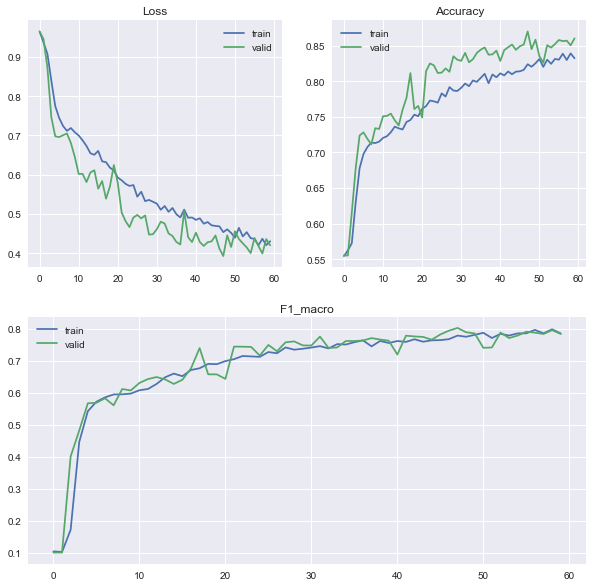

In [19]:
# 指定数据维度和时间步等参数
data_dim = 200
timesteps = 8
num_classes = 3

# 模型一: lstm_part_1_066.h5
model_1 = Sequential()
model_1.add(LSTM(256, return_sequences=True, input_shape=(timesteps, data_dim)))
model_1.add(LSTM(256, return_sequences=True))
model_1.add(LSTM(256))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(num_classes, activation='softmax'))

# loss: categorical_crossentropy
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', metric_F1_macro])
model_1.summary()
# 模型训练
history = model_1.fit(train_feature_part_1, train_label_part_1, batch_size=256, epochs=60, validation_data=(valid_feature_part_1, valid_label_part_1), verbose=1)
# 画图
draw_plot(history=history)

In [ ]:
## 保存第一部分模型
# model_1.save("./model/lstm_part_1_066.h5")
model_1 = load_model("model/lstm_part_1_066.h5", custom_objects={"metric_F1_macro": metric_F1_macro})

## 6. 第二阶段: 训练二分类网络

In [20]:
df_data = pd.read_pickle('./model/template/cpu_diag_comp_sel_log_all_feature1h_3_sum.pkl')

In [21]:
df_train_label = pd.read_csv('./data/train/preliminary_train_label_dataset.csv')
df_train_label_s = pd.read_csv('./data/train/preliminary_train_label_dataset_s.csv')
df_train_label = pd.concat([df_train_label, df_train_label_s])
df_train_label = df_train_label.drop_duplicates(['sn','fault_time','label'])

## 只分别01
df_train_label = df_train_label[(df_train_label.label == 0) | df_train_label.label == 1]

df_data_train = pd.merge(df_data[df_data.sn.isin(df_train_label.sn)],df_train_label, on='sn', how='left')
y = df_data_train['label']
x = df_data_train.drop(['sn','collect_time_gap','fault_time','label'],axis=1)

In [12]:
# 使用贝叶斯优化寻找最佳配置
# 定义目标函数
def rf_cv(n_estimators, num_leaves, max_depth, learning_rate):
    val = cross_val_score(
        ## 决策树
        lgb.LGBMClassifier(
            n_estimators=int(n_estimators),
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            random_state=2022,
            boosting_type="gbdt",
            objective="binary"
        ),
        x, y, scoring='f1_macro', cv=100
    ).mean()
    return val
# 定义贝叶斯优化
rf_bo = BayesianOptimization(
        rf_cv,
        {
            'n_estimators': (10, 500),
            'num_leaves': (8, 32),
            'max_depth': (2, 10),
            'learning_rate': (0.005, 0.1)
        }
    )
# 寻找目标值最大的配置
rf_bo.maximize()

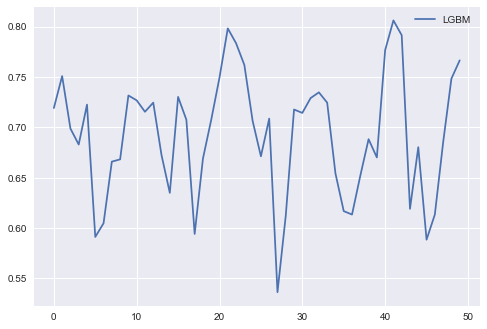

In [22]:
# 随机森林 0.66
clf = RandomForestClassifier(criterion='entropy', oob_score=True, random_state=2022)
clf_s = cross_val_score(clf, x, y, cv=50, verbose=0, scoring="accuracy")
clf.fit(x, y)
y2 = clf.predict(x)

plt.style.use("seaborn")
plt.plot(range(len(clf_s)), clf_s, label = "LGBM")
plt.legend()
plt.show()

In [23]:
# 训练集上01分类的效果
for i in range(2):
    TP = np.sum(y[y2==i]==i)
    FP = np.sum(y[y2==i]!=i)
    FN = np.sum(y[y2!=i]==i)
    precision = TP /  (TP + FP)  if  (TP + FP)  >  0  else  0
    recall = TP /  (TP + FN)  if  (TP + FN)  >  0  else  0
    F1 =  2  * precision * recall /  (precision + recall)  if  (precision + recall)  >  0  else  0
    print("%.4f" % F1)

0.6881
0.7033


## 7. 预测并保存结果

In [24]:
## 评价函数
def macro_f1(target_df,  submit_df):
	weights =  [3/7,  2/7,  1/7,  1/7]
	
	overall_df = target_df.merge(submit_df, how='left', on=['sn', 'fault_time'], suffixes=['_gt', '_pr'])
	overall_df.fillna(-1)

	macro_F1 =  0.
	for i in range(len(weights)):
		TP =  len(overall_df[(overall_df['label_gt'] == i) & (overall_df['label_pr'] == i)])
		FP =  len(overall_df[(overall_df['label_gt'] != i) & (overall_df['label_pr'] == i)])	
		FN =  len(overall_df[(overall_df['label_gt'] == i) & (overall_df['label_pr'] != i)])
		precision = TP /  (TP + FP)  if  (TP + FP)  >  0  else  0
		recall = TP /  (TP + FN)  if  (TP + FN)  >  0  else  0
		F1 =  2  * precision * recall /  (precision + recall)  if  (precision + recall)  >  0  else  0
		print("%d %.2f %.2f %.2f" % (i, F1, precision, recall))
		macro_F1 += weights[i]  * F1
	return macro_F1

In [25]:
### 使用valid信息进行预测
#### 第一阶段
valid_label_pre = model_1.predict(valid_feature_part_1)
valid_label_pre = [np.argmax(x) for x in valid_label_pre]
valid_label_pre = np.array(valid_label_pre)
valid_label_pre = np.where(valid_label_pre == 2, 3, valid_label_pre)
valid_label_pre = np.where(valid_label_pre == 1, 2, valid_label_pre)

data_2 = valid_data[valid_label_pre==0][['sn','fault_time']]
x_test = []
for i in tqdm(range(len(data_2))):
    x_test.append(df_data[df_data.sn==data_2.iloc[i].sn].tail(1))
    
x_test = np.array(x_test)
x_test = x_test.squeeze(1)
x_test = x_test[:,2:]
valid_label_pre_2 = clf.predict(x_test)
valid_label_pre[valid_label_pre==0] = valid_label_pre_2

valid_pre = valid_data.copy()
valid_pre['label'] = valid_label_pre
print("Random Forest Macro_f1", macro_f1(valid_data, valid_pre))

100%|██████████| 1342/1342 [00:14<00:00, 92.00it/s]


0 0.46 0.70 0.35
1 0.80 0.77 0.82
2 0.93 0.90 0.95
3 0.79 0.80 0.78
Random Forest Macro_f1 0.6700926842551295


In [26]:
## 预测并提交结果
test_label = model_1.predict(test_feature)
test_label = [np.argmax(x) for x in test_label]
test_label = np.array(test_label)
test_label = np.where(test_label == 2, 3, test_label)
test_label = np.where(test_label == 1, 2, test_label)

data_2 = submit[test_label==0][['sn','fault_time']]
x_test = []
for i in tqdm(range(len(data_2))):
    x_test.append(df_data[df_data.sn==data_2.iloc[i].sn].tail(1))
    
x_test = np.array(x_test)
x_test = x_test.squeeze(1)
x_test = x_test[:,2:]
test_label_2 = clf.predict(x_test)

test_label[test_label==0] = test_label_2
submit['label'] = test_label

submit.to_csv('./preliminary_submit_dataset_b.csv', index=0)

100%|██████████| 923/923 [00:10<00:00, 89.19it/s]
